# Linear Regression with Stellar Spectra: Understanding Uncertainty

- By Yuan-Sen Ting, February 2025, for Astron 5550

Our previous tutorial introduced linear regression for predicting stellar temperatures from spectra. While we achieved reasonable predictions, we didn't deeply consider the uncertainties in our model. Understanding uncertainty is crucial in astronomy - knowing how confident we are in our predictions is often as important as the predictions themselves.

## Prerequisites

Before diving into this tutorial, you should be familiar with:
- Basic concepts from our previous linear regression tutorial
- Fundamentals of probability theory and statistics
- Basic understanding of Bayesian inference

## What You'll Learn

This tutorial presents a unified treatment of uncertainty in linear regression. We begin with simple error estimation, showing why naive approaches can be misleading. We then explore how incorporating measurement uncertainties improves our models. Finally, we develop a full Bayesian treatment that naturally handles all sources of uncertainty.

Through this progression, you'll learn to:
- Properly estimate and interpret prediction uncertainties
- Account for measurement noise in your data
- Use Bayesian methods for robust uncertainty quantification
- Make reliable predictions with well-calibrated error bars

Let's begin by setting up our Python environment:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

# Set plotting parameters for better visualization
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# For reproducibility
np.random.seed(42)

Now let's load our APOGEE stellar spectra dataset. This dataset contains:
- Stellar spectra: flux measurements at different wavelengths
- Wavelength array: corresponding wavelengths for each flux measurement
- Temperature array: measured effective temperatures for each star

In [2]:
# Load our dataset
file = np.load('dataset_apogee_spectra.npz')
spectra = file['spectrum_array']
wavelength = file['wavelength']
teff_array = file['teff_array']

# Print basic information about our dataset
print(f"Number of stars: {len(spectra)}")
print(f"Flux per spectrum: {len(wavelength)}")
print(f"Temperature range: {np.min(teff_array):.0f}K - {np.max(teff_array):.0f}K")

Number of stars: 6500
Flux per spectrum: 7214
Temperature range: 3122K - 6997K


For our linear regression model, we'll use the first 2000 wavelength points from each spectrum. We also add a bias term to handle the base temperature level. Our design matrix $\Phi$ will have dimensions ($N_{stars}$ × 2001), where the last column is the bias term:

In [3]:
# Prepare design matrix
Phi = spectra[:,:2000]  # First 2000 wavelength points
Phi = np.hstack((Phi, np.ones((Phi.shape[0], 1))))  # Add bias term

# Split into training and test sets
Phi_train, Phi_test, t_train, t_test = train_test_split(
    Phi, teff_array, test_size=0.2, random_state=42)

print("\nData shapes:")
print(f"Training features: {Phi_train.shape}")
print(f"Training labels: {t_train.shape}")
print(f"Test features: {Phi_test.shape}")
print(f"Test labels: {t_test.shape}")


Data shapes:
Training features: (5200, 2001)
Training labels: (5200,)
Test features: (1300, 2001)
Test labels: (1300,)


## Part 1: Why Naive Error Estimates Can Be Misleading

Let's start with the simplest approach to error estimation in linear regression. Given our design matrix $\boldsymbol{\Phi}$ and temperature measurements $\mathbf{t}$, the ordinary least squares solution is:

$$\mathbf{w}_{\text{ML}} = (\boldsymbol{\Phi}^T\boldsymbol{\Phi})^{-1}\boldsymbol{\Phi}^T\mathbf{t}$$

A common practice is to estimate uncertainty by computing the root mean squared error (RMSE) on the training data:

$$\sigma_{\text{naive}} = \sqrt{\frac{1}{N}\sum_{n=1}^N(t_n - \mathbf{w}_{\text{ML}}^T\boldsymbol{\phi}_n)^2}$$

As we saw in Lecture 4, this is equivalent to the maximum likelihood estimation (MLE) where we jointly fit for both the weights $\mathbf{w}$ and the noise variance $\sigma^2$. Under the assumption of Gaussian noise, the likelihood is:

$$p(\mathbf{t}|\boldsymbol{\Phi}, \mathbf{w}, \sigma^2) = \prod_{n=1}^N \mathcal{N}(t_n|\mathbf{w}^T\boldsymbol{\phi}_n, \sigma^2)$$

Taking derivatives of the log-likelihood with respect to both $\mathbf{w}$ and $\sigma^2$ and setting them to zero gives us exactly these solutions for $\mathbf{w}_{\text{ML}}$ and $\sigma_{\text{naive}}^2$. Let's implement this naive approach and examine its limitations:

To understand why this naive MLE approach can be misleading, let's look at what happens when we fit our data:

MLE estimate of uncertainty (σ): 72.4K
Actual test uncertainty (σ): 131.5K


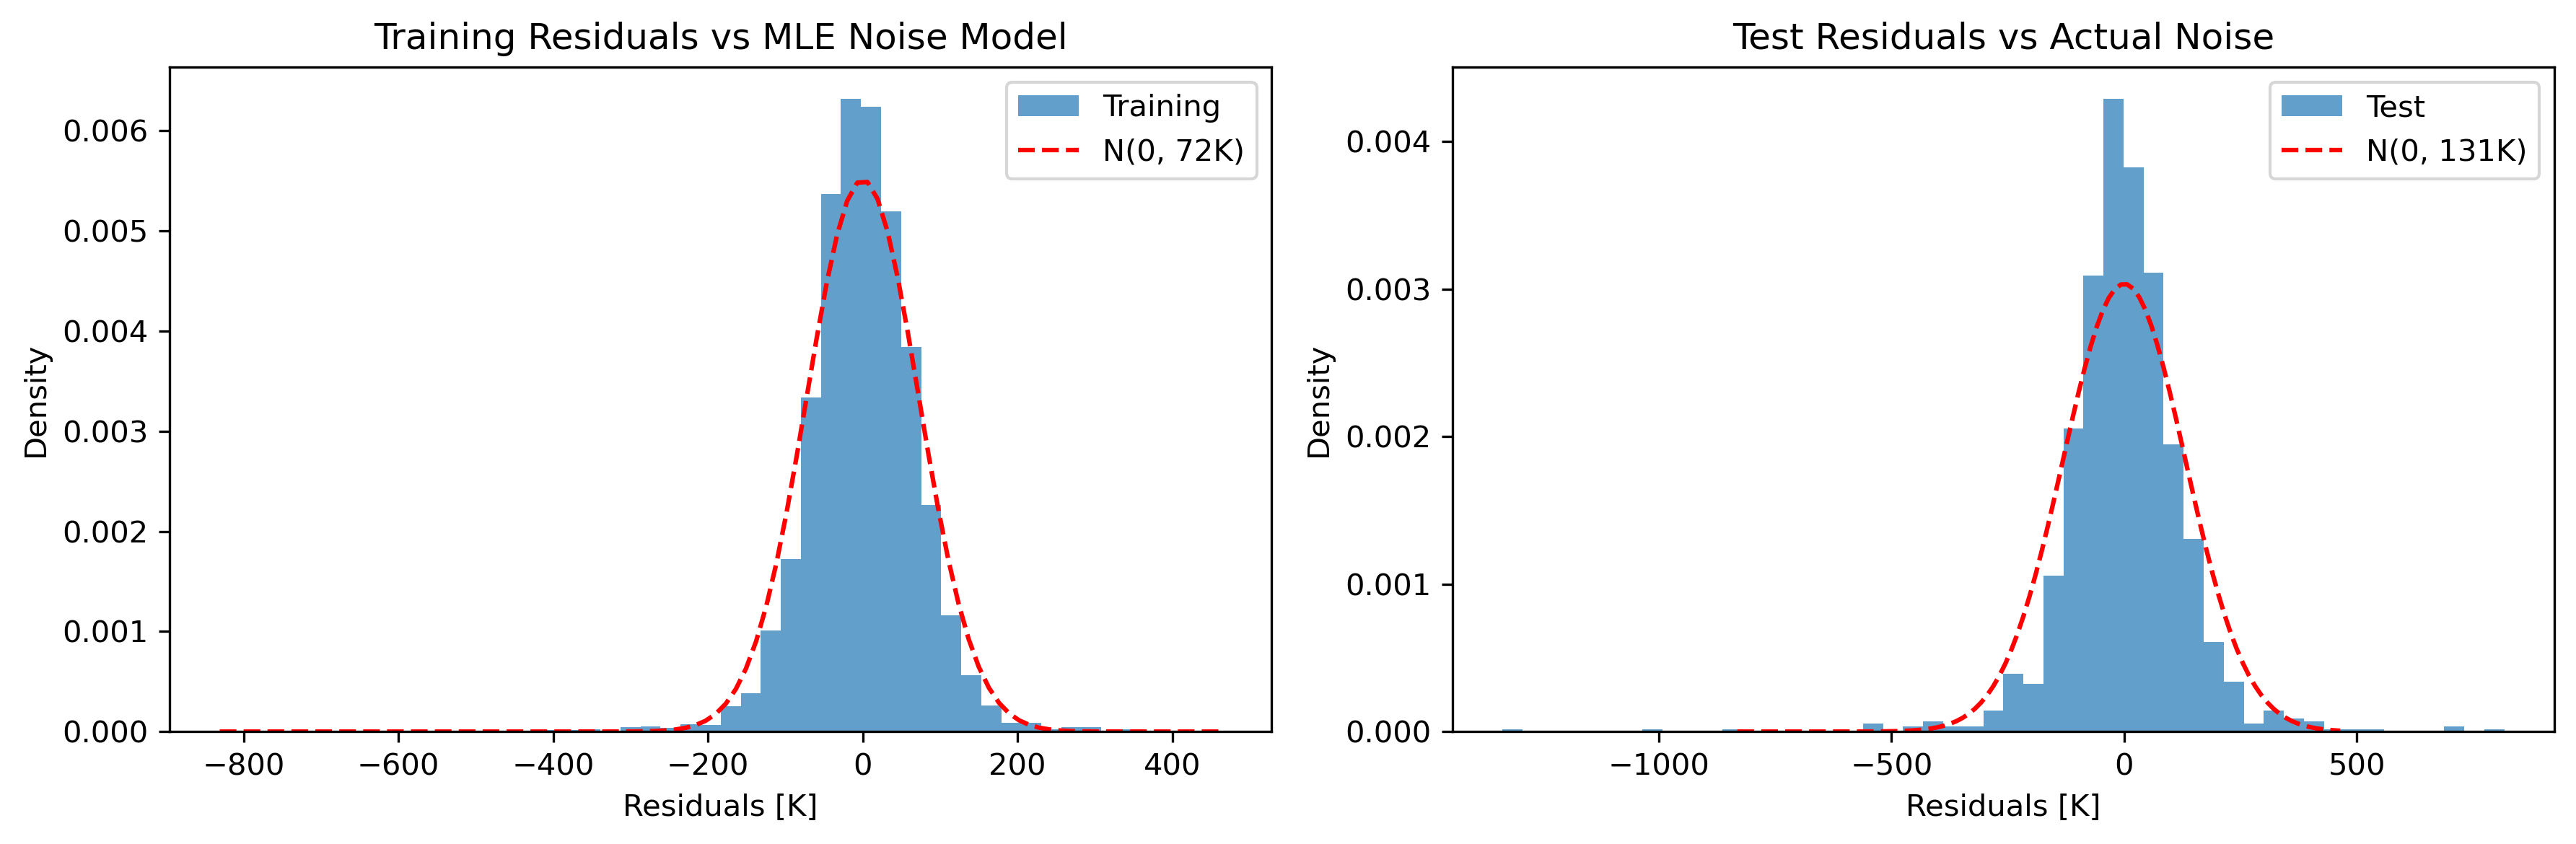

In [4]:
def fit_naive_mle(Phi_train, t_train, Phi_test, t_test):
    """
    Fit linear regression using naive MLE for both weights and noise variance
    """
    # Compute MLE solution for weights
    w_ml = np.linalg.inv(Phi_train.T @ Phi_train) @ Phi_train.T @ t_train
    
    # Compute predictions
    pred_train = Phi_train @ w_ml
    pred_test = Phi_test @ w_ml
    
    # Compute MLE for noise variance (naive)
    residuals_train = t_train - pred_train
    sigma_mle = np.sqrt(np.mean(residuals_train**2))
    
    # Compute test residuals
    residuals_test = t_test - pred_test
    sigma_test = np.sqrt(np.mean(residuals_test**2))
    
    return w_ml, sigma_mle, sigma_test, pred_train, pred_test

# Fit model and get metrics
w_ml, sigma_mle, sigma_test, pred_train, pred_test = fit_naive_mle(
    Phi_train, t_train, Phi_test, t_test)

print(f"MLE estimate of uncertainty (σ): {sigma_mle:.1f}K")
print(f"Actual test uncertainty (σ): {sigma_test:.1f}K")

# Visualize the residuals
plt.figure(figsize=(12, 4))

# Training residuals
plt.subplot(121)
residuals_train = t_train - pred_train
plt.hist(residuals_train, bins=50, density=True, alpha=0.7, label='Training')
x = np.linspace(min(residuals_train), max(residuals_train), 100)
plt.plot(x, stats.norm.pdf(x, 0, sigma_mle), 'r--', 
         label=f'N(0, {sigma_mle:.0f}K)')
plt.xlabel('Residuals [K]')
plt.ylabel('Density')
plt.title('Training Residuals vs MLE Noise Model')
plt.legend()

# Test residuals
plt.subplot(122)
residuals_test = t_test - pred_test
plt.hist(residuals_test, bins=50, density=True, alpha=0.7, label='Test')
plt.plot(x, stats.norm.pdf(x, 0, sigma_test), 'r--', 
         label=f'N(0, {sigma_test:.0f}K)')
plt.xlabel('Residuals [K]')
plt.ylabel('Density')
plt.title('Test Residuals vs Actual Noise')
plt.legend()

plt.tight_layout()
plt.show()

The plots reveal a crucial problem: our MLE estimate of uncertainty significantly underestimates the true prediction errors. This happens because:

1. The MLE approach gives us the noise level that makes our training data most likely, given our model. However, when we have many parameters ($M = 2001$ in our case), the model can fit noise in the training data, making the residuals artificially small.

2. This effect gets worse as we increase model complexity. Let's see this by varying how many spectral features we use:

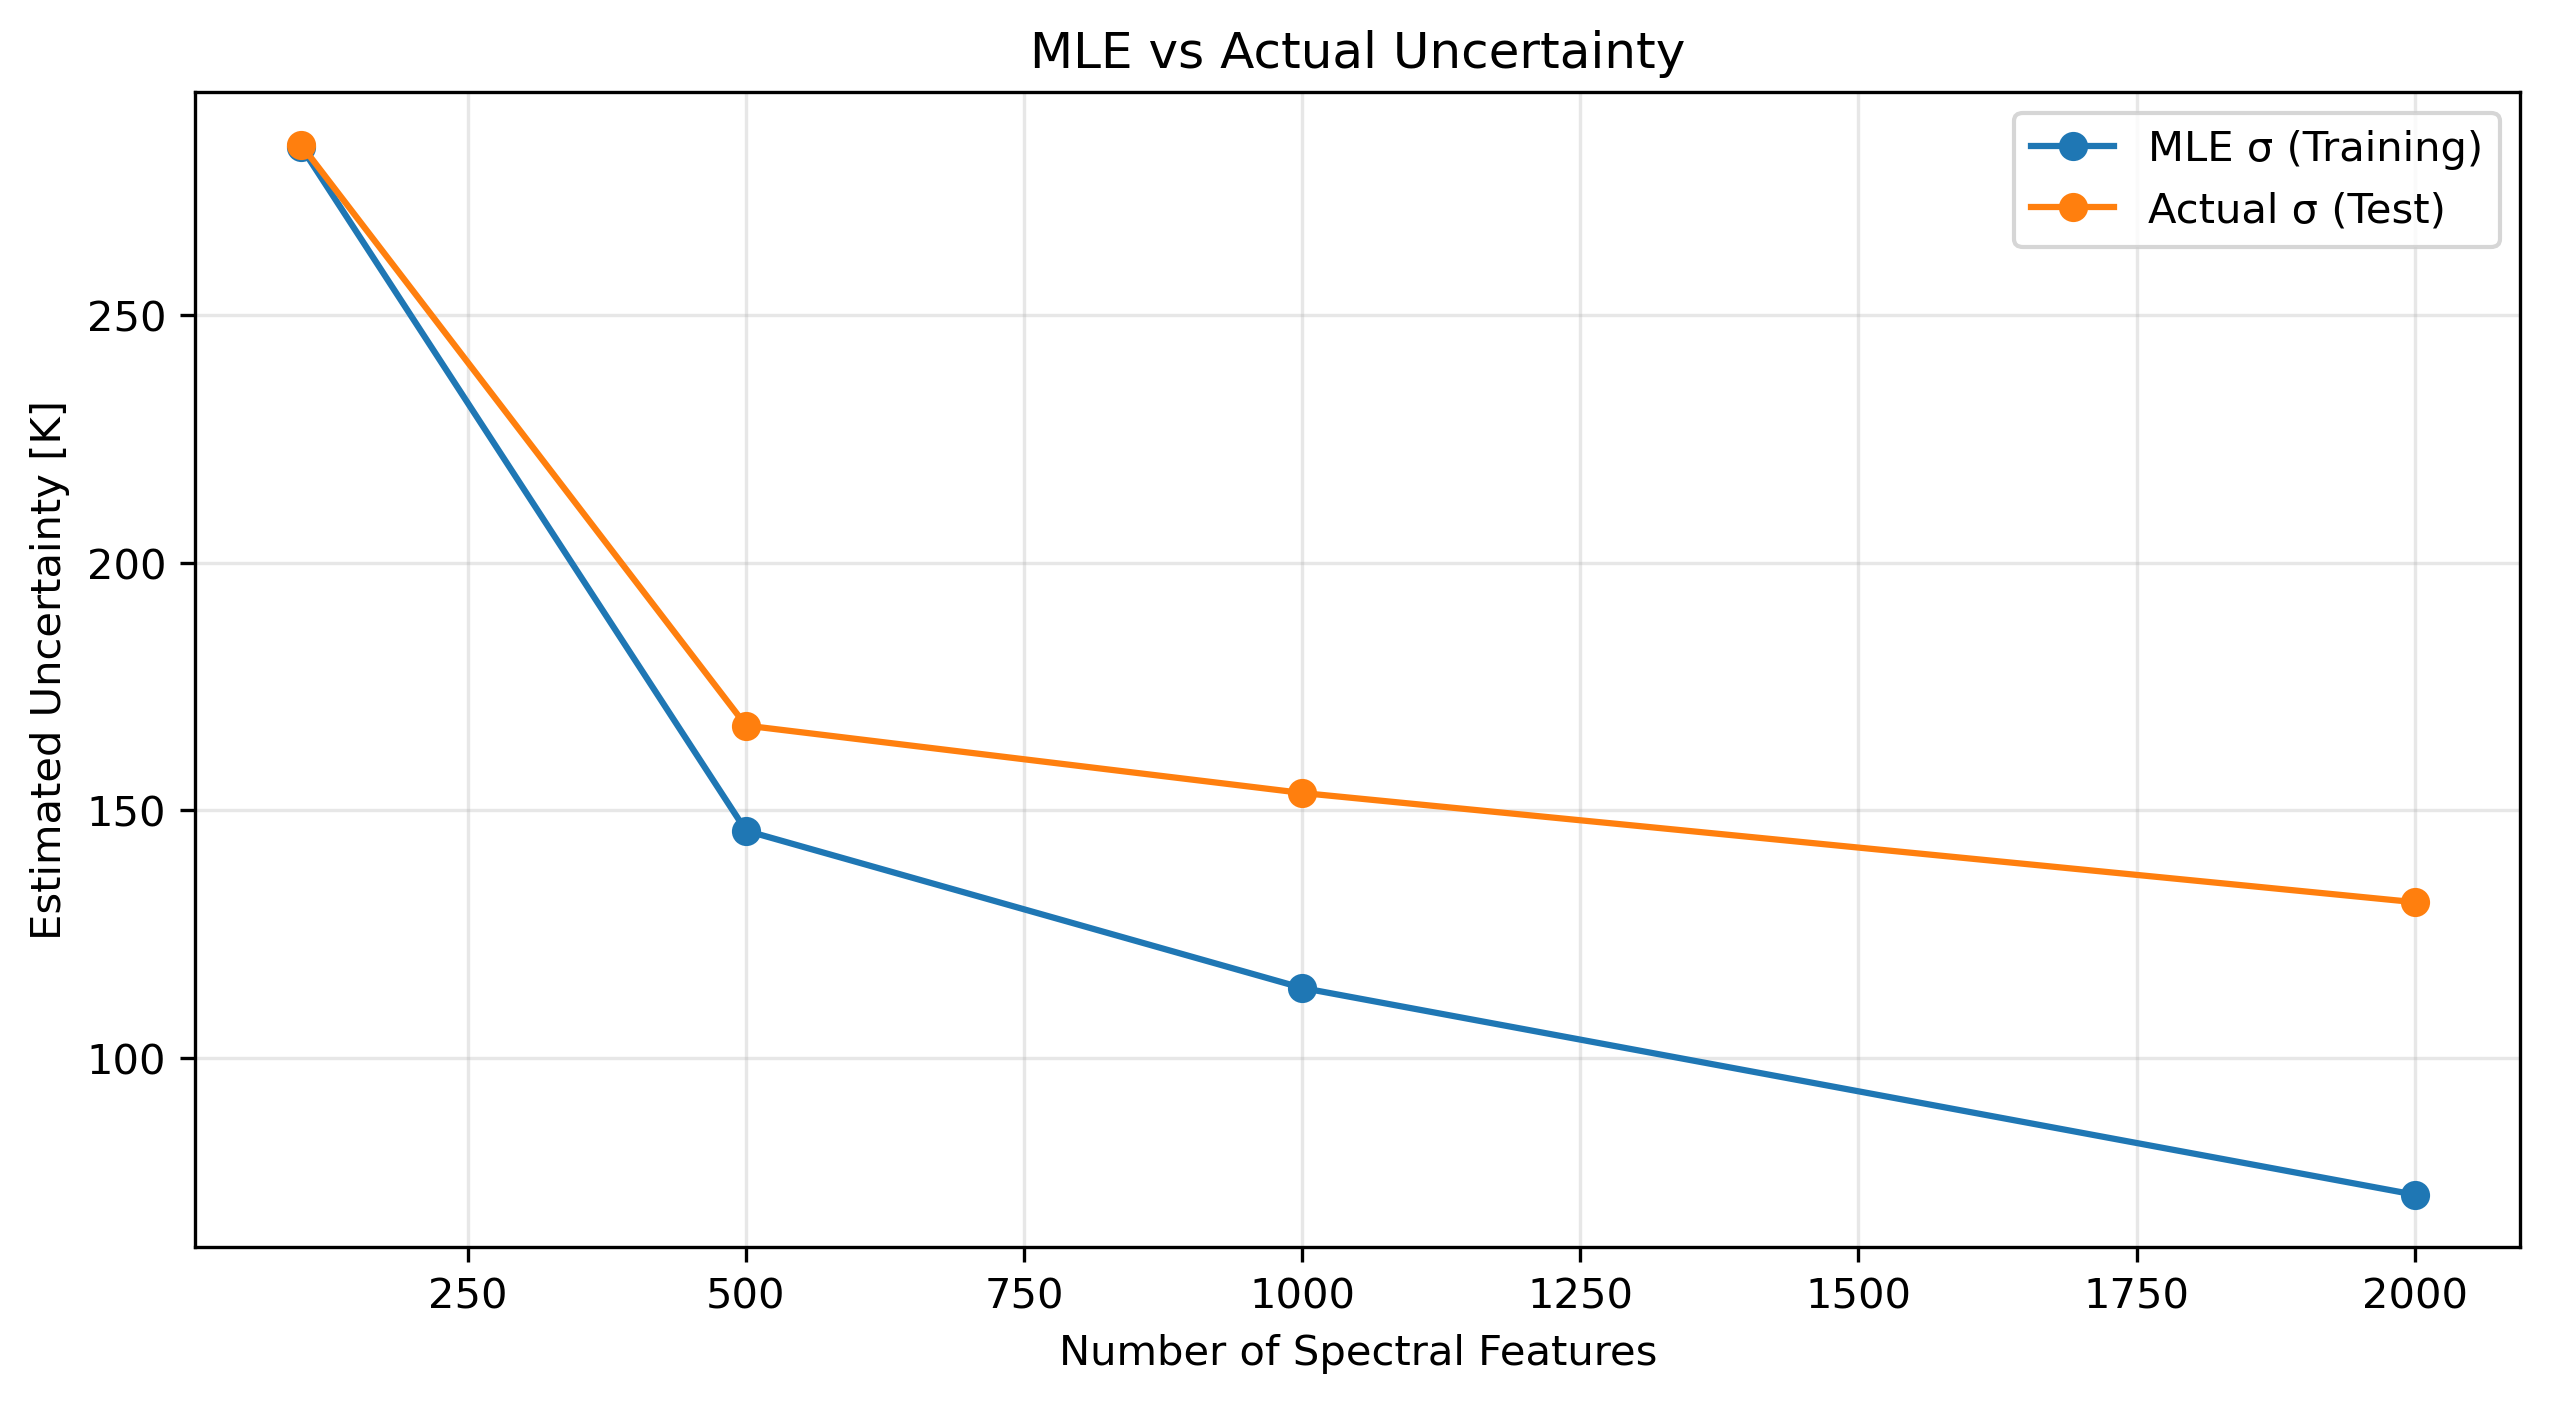

In [5]:
# Compare models with different numbers of features
n_features = [100, 500, 1000, 2000]
results = []

for n in n_features:
    # Prepare design matrices with n features
    Phi_n = np.hstack((spectra[:,:n], np.ones((len(spectra), 1))))
    Phi_train_n, Phi_test_n, t_train_n, t_test_n = train_test_split(
        Phi_n, teff_array, test_size=0.2, random_state=42)
    
    # Fit and evaluate
    w_ml, sigma_mle, sigma_test, _, _ = fit_naive_mle(
        Phi_train_n, t_train_n, Phi_test_n, t_test_n)
    
    results.append((n, sigma_mle, sigma_test))

# Plot results
plt.figure(figsize=(10, 5))
features, mle_sigma, test_sigma = zip(*results)

plt.plot(features, mle_sigma, 'o-', label='MLE σ (Training)')
plt.plot(features, test_sigma, 'o-', label='Actual σ (Test)')
plt.xlabel('Number of Spectral Features')
plt.ylabel('Estimated Uncertainty [K]')
plt.title('MLE vs Actual Uncertainty')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

This clearly shows how the naive MLE approach becomes increasingly misleading as model complexity grows. To fix this, we need to:

1. Account for model complexity in our uncertainty estimates
2. Consider uncertainty in our parameter estimates
3. Incorporate prior knowledge about reasonable parameter values

One way to start addressing these issues is through regularization, which we'll explore next. The key insight is that by adding a penalty on parameter values:

$$E(\mathbf{w}) = \frac{1}{2}\sum_{n=1}^N(t_n - \mathbf{w}^T\boldsymbol{\phi}_n)^2 + \frac{\lambda}{2}\|\mathbf{w}\|^2$$

we implicitly express prior knowledge that weights should be small, preventing the model from fitting noise in the training data.

### Regularization and Uncertainty

Adding L2 regularization (ridge regression) modifies our optimization problem:

$$E(\mathbf{w}) = \frac{1}{2}\sum_{n=1}^N(t_n - \mathbf{w}^T\boldsymbol{\phi}_n)^2 + \frac{\lambda}{2}\|\mathbf{w}\|^2$$

The regularized solution becomes:

$$\mathbf{w}_{\text{reg}} = (\boldsymbol{\Phi}^T\boldsymbol{\Phi} + \lambda\mathbf{I})^{-1}\boldsymbol{\Phi}^T\mathbf{t}$$

Interestingly, this can be interpreted probabilistically - it's equivalent to assuming a Gaussian prior on weights with variance $1/\lambda$. Let's see how regularization affects our uncertainty estimates:

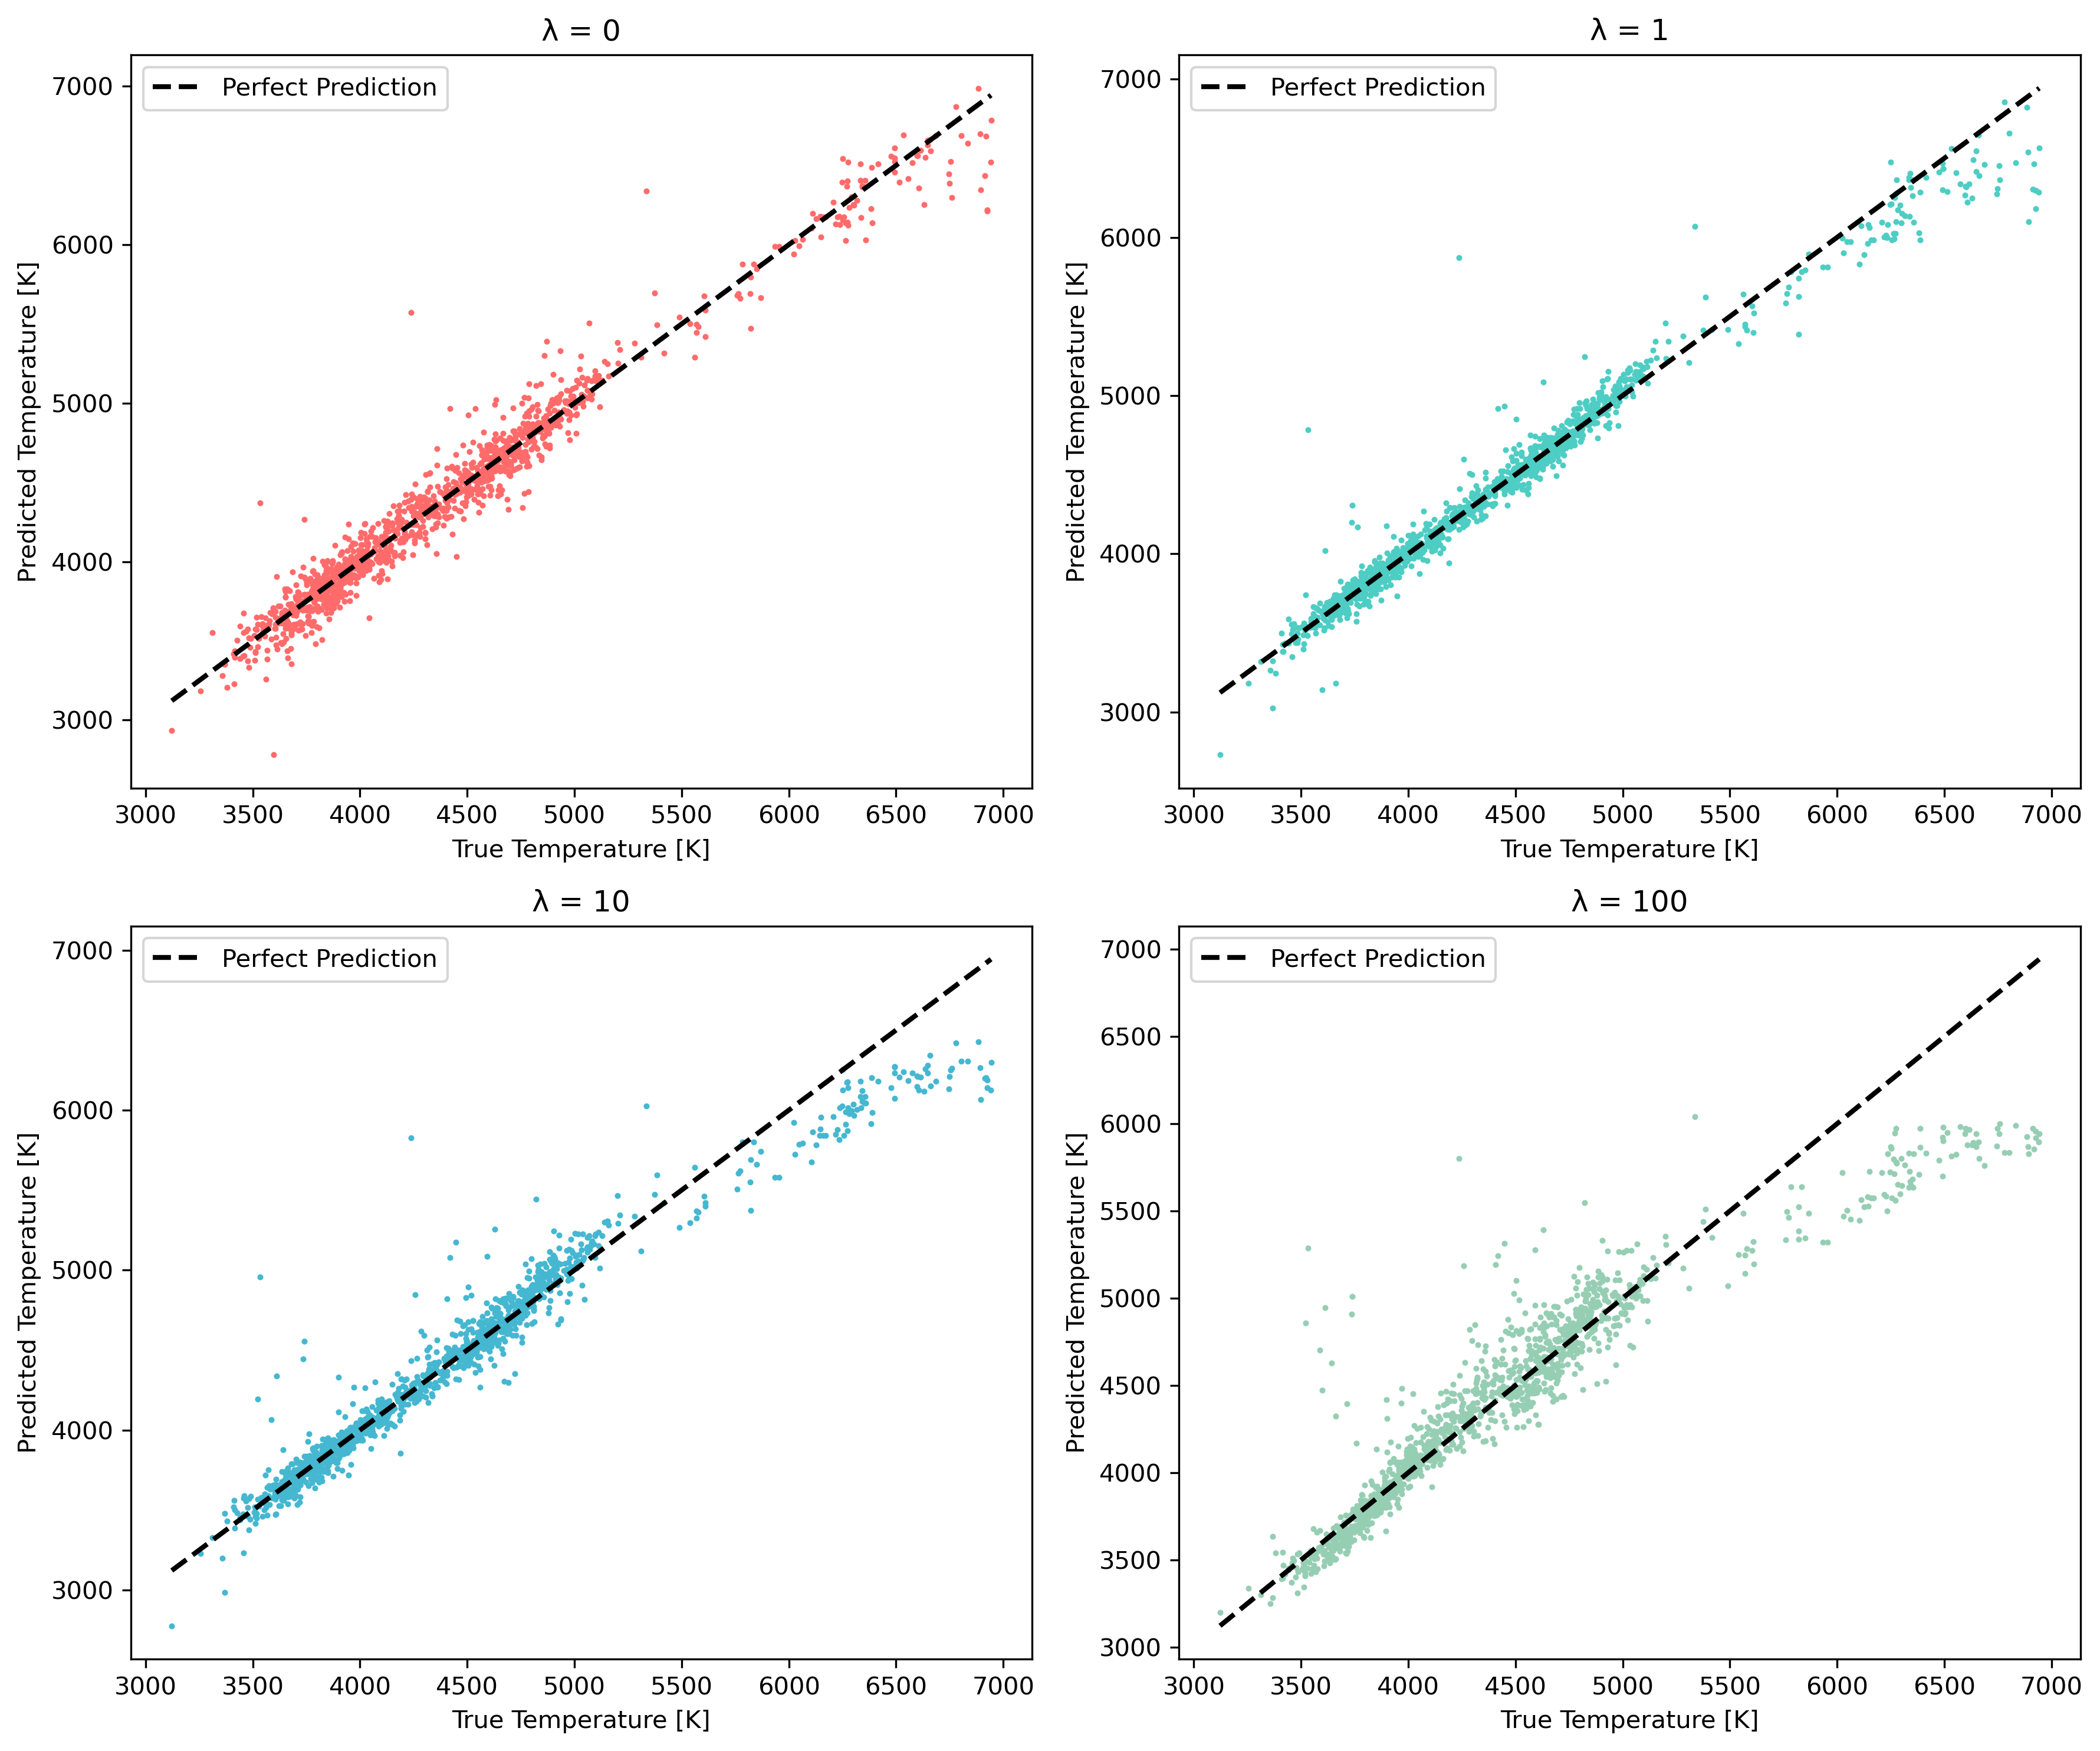


Regularization Effects:
λ	Train σ	Test σ
------------------------------
0	72.4K	131.5K
1	112.2K	120.3K
10	161.1K	160.2K
100	258.7K	252.8K


In [6]:
def fit_regularized(Phi_train, t_train, Phi_test, t_test, lambda_reg):
    """
    Fit ridge regression with different regularization strengths
    """
    # Number of features
    M = Phi_train.shape[1]
    
    # Compute regularized solution
    w_reg = np.linalg.inv(Phi_train.T @ Phi_train + lambda_reg * np.eye(M)) @ Phi_train.T @ t_train
    
    # Compute predictions
    pred_train = Phi_train @ w_reg
    pred_test = Phi_test @ w_reg
    
    # Compute noise estimates
    sigma_train = np.sqrt(np.mean((t_train - pred_train)**2))
    sigma_test = np.sqrt(np.mean((t_test - pred_test)**2))
    
    return w_reg, sigma_train, sigma_test, pred_train, pred_test

# Try different regularization strengths
lambdas = [0, 1, 10, 100]
reg_results = []

# Define beautiful colors for each lambda
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for lambda_reg in lambdas:
    w_reg, sigma_train, sigma_test, pred_train, pred_test = fit_regularized(
        Phi_train, t_train, Phi_test, t_test, lambda_reg)
    reg_results.append((lambda_reg, sigma_train, sigma_test))

# Plot results in subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, ((lambda_reg, sigma_train, sigma_test), ax, color) in enumerate(zip(reg_results, axes, colors)):
    w_reg = fit_regularized(Phi_train, t_train, Phi_test, t_test, lambda_reg)[0]
    ax.scatter(t_test, Phi_test @ w_reg, alpha=1, s=2, color=color)
    
    # Add perfect prediction line
    ax.plot([t_test.min(), t_test.max()], 
            [t_test.min(), t_test.max()], 
            'k--', linewidth=2, label='Perfect Prediction')
    
    ax.set_xlabel('True Temperature [K]')
    ax.set_ylabel('Predicted Temperature [K]')
    ax.set_title(f'λ = {lambda_reg}')
    ax.legend()

plt.tight_layout()
plt.show()

# Print metrics
print("\nRegularization Effects:")
print("λ\tTrain σ\tTest σ")
print("-" * 30)
for lambda_reg, sigma_train, sigma_test in reg_results:
    print(f"{lambda_reg}\t{sigma_train:.1f}K\t{sigma_test:.1f}K")

We can see that regularization helps in several ways:

1. **Reduced Overfitting**: The gap between training and test uncertainties shrinks
2. **More Realistic Estimates**: Our uncertainty estimates become more conservative

However, regularization alone doesn't solve all our problems:

1. We still treat all measurements as equally reliable, which isn't true in practice
2. We don't have a principled way to choose the regularization strength λ
3. We're still just getting point estimates, not full uncertainty quantification

These limitations lead us naturally to Part 2, where we'll properly account for measurement uncertainties in our data. In APOGEE, different stars have different measurement uncertainties - some temperature measurements are more reliable than others. Incorporating this information will give us a more principled approach to uncertainty estimation.

## Part 2: Incorporating Measurement Uncertainties

In Part 1, we saw how naive error estimates can be misleading, even with regularization. A key issue we ignored is that different temperature measurements have different uncertainties. For example, in APOGEE:

- Cool stars (T < 4000K) typically have more precise temperatures due to rich molecular features
- Hot stars (T > 6000K) often have larger uncertainties due to fewer spectral lines
- Observing conditions and signal-to-noise ratios vary between stars

Let's simulate this heteroscedastic (varying) noise in our data. We'll assume temperature uncertainties increase linearly with temperature:

$$ \sigma_{\text{teff}, n} = 50 + 150 \cdot \frac{t_n - t_{\text{min}}}{t_{\text{max}} - t_{\text{min}}} $$

In [7]:
# Simulate heteroscedastic noise: noise increases with temperature.
sigma_teff = 50 + 150 * (teff_array - teff_array.min()) / (teff_array.max() - teff_array.min())
noisy_teff = teff_array + np.random.normal(0, sigma_teff)

# Prepare the design matrix (using first 2000 wavelength points and add bias term)
Phi = spectra[:, :2000]
Phi = np.hstack([Phi, np.ones((len(Phi), 1))])

# Train/test split (also split the per-star uncertainties)
Phi_train, Phi_test, t_train, t_test, sigma_train, sigma_test = train_test_split(
    Phi, noisy_teff, sigma_teff, test_size=0.2, random_state=42)

print("Shapes:")
print("Phi_train:", Phi_train.shape)
print("t_train:", t_train.shape)

Shapes:
Phi_train: (5200, 2001)
t_train: (5200,)


For homogeneous noise with variance $\sigma^2$, the maximum likelihood solution is:
 
$$\mathbf{w}_{\text{ML}} = (\boldsymbol{\Phi}^T\boldsymbol{\Phi})^{-1} \boldsymbol{\Phi}^T\mathbf{t}$$
 
When each observation has its own noise variance $\sigma_n^2$, the weighted least squares (maximum likelihood) solution becomes:
 
$$\mathbf{w}_{\text{ML}} = (\boldsymbol{\Phi}^T\mathbf{S}^{-1}\boldsymbol{\Phi})^{-1} \boldsymbol{\Phi}^T\mathbf{S}^{-1}\mathbf{t}$$
 
where $\mathbf{S}$ is a diagonal matrix with entries $\sigma_n^2$. Let's implement this:

In [8]:
# Compute weights for each training example: w_n = 1/σ_n^2
weights = 1 / sigma_train**2

# Weight the design matrix and target vector accordingly
weighted_Phi = Phi_train * weights[:, np.newaxis]
weighted_t = t_train * weights

# Solve for the weights using the weighted least squares formula:
# w_hetero = (Phi^T (W) Phi)^{-1} Phi^T (W) t
w_hetero = np.linalg.inv(Phi_train.T @ (Phi_train * weights[:, np.newaxis])) @ (Phi_train.T @ weighted_t)

# Predictions on the test set using the weighted model
pred = Phi_test @ w_hetero

# Normalized residuals: (observed - predicted) / σ
resid = (t_test - pred) / sigma_test

print(f"Weighted Model χ² (mean squared normalized residual): {np.mean(resid**2):.2f}")
print(f"Weighted Model RMS Residual: {np.sqrt(np.mean((t_test - pred)**2)):.1f} K")
print(f"Weighted Model Median |Residual/σ|: {np.median(np.abs(resid)):.2f}")

Weighted Model χ² (mean squared normalized residual): 3.22
Weighted Model RMS Residual: 182.5 K
Weighted Model Median |Residual/σ|: 1.07


While the weighted least squares solution involves the inverse noise covariance matrix $\mathbf{S}^{-1}$, we can compute it efficiently without explicitly constructing this large matrix. Since $\mathbf{S}$ is diagonal with entries $\sigma_n^2$, its inverse $\mathbf{S}^{-1}$ is also diagonal with entries $1/\sigma_n^2$. When we write:

```
weights = 1 / sigma_train**2
weighted_Phi = Phi_train * weights[:, np.newaxis]
weighted_t = t_train * weights
```

We're exploiting this diagonal structure. For each star $n$, we're scaling row $n$ of $\boldsymbol{\Phi}$ by $1/\sigma_n^2$ and element $n$ of $\mathbf{t}$ by $1/\sigma_n^2$. This is mathematically equivalent to the matrix operations $\mathbf{S}^{-1}\boldsymbol{\Phi}$ and $\mathbf{S}^{-1}\mathbf{t}$, but without constructing the full $N \times N$ matrix $\mathbf{S}^{-1}$. Then, when we compute:

```
w_hetero = np.linalg.inv(Phi_train.T @ (Phi_train * weights[:, np.newaxis])) @ (Phi_train.T @ weighted_t)
```

We're effectively calculating $(\boldsymbol{\Phi}^T\mathbf{S}^{-1}\boldsymbol{\Phi})^{-1}\boldsymbol{\Phi}^T\mathbf{S}^{-1}\mathbf{t}$ in a numerically stable way. This approach saves memory by avoiding large matrix construction and improves numerical stability by working with standard deviations directly. Moreover, the code becomes more readable by showing the weighting explicitly in our operations.

The chi-squared statistic gives us important information about our model:

1. $\chi^2 \approx 1$ would indicate our uncertainties are well-estimated
2. Our current value suggests some model inadequacy or underestimated uncertainties
3. The median normalized residual shows typical prediction errors relative to uncertainties

Let's compare with an unweighted model:

In [9]:
# Fit the homogeneous (ordinary least squares) model
w_homo = np.linalg.inv(Phi_train.T @ Phi_train) @ (Phi_train.T @ t_train)
pred_homo = Phi_test @ w_homo

# Normalized residuals for the homogeneous model
resid_homo = (t_test - pred_homo) / sigma_test

print(f"\nHomogeneous Model χ²: {np.mean(resid_homo**2):.2f}")


Homogeneous Model χ²: 3.78


The weighted least squares approach improves our model by properly accounting for measurement uncertainties. However, several challenges remain with this approach. First, while our $\chi^2$ value appears reasonable, it still deviates from the ideal value of $\chi^2 \approx 1$. This deviation suggests potential issues: our linear model may be overly simplistic for the complex relationships in the data, we might be underestimating some uncertainties in our measurements, and importantly, we're not accounting for any uncertainty in our weights $\mathbf{w}$.

Another limitation is our treatment of the uncertainty estimates themselves. We handle the $\sigma_n$ values as if they were perfectly known quantities, when in reality these estimates carry their own uncertainties. This assumption of perfect uncertainty measurements could lead to overconfidence in some predictions and underconfidence in others.

Perhaps most importantly, our current approach provides no natural mechanism for incorporating valuable prior knowledge about the system. For instance, we know that stellar temperatures typically fall within a specific range (roughly $3000\text{K}$ to $8000\text{K}$), spectral features tend to vary smoothly rather than abruptly, and there are physical relationships between different wavelengths. These important physical constraints and relationships cannot be naturally expressed within the weighted least squares framework.



## Part 3: Bayesian Linear Regression

To address these limitations, we turn to Bayesian regression. Instead of finding single "best" values for our weights, we'll compute a full posterior distribution:

$$p(\mathbf{w}|\mathbf{t}, \boldsymbol{\Phi}, \boldsymbol{\Sigma}) = \mathcal{N}(\mathbf{w}|\mathbf{m}_N, \mathbf{S}_N)$$

where:
- $\mathbf{m}_N$ is the posterior mean (2001-dimensional vector)
- $\mathbf{S}_N$ is the posterior covariance (2001 × 2001 matrix)
- $\boldsymbol{\Sigma}$ is our diagonal matrix of measurement variances

The Bayesian approach requires us to specify a prior on weights. A common choice is a zero-mean Gaussian:

$$p(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{0}, \eta^2\mathbf{I})$$

where $\eta^2$ controls how strongly we believe weights should be close to zero. Let's implement this and explore how different prior strengths affect our predictions:

Let's implement the Bayesian posterior computation. For our Gaussian likelihood and prior, the posterior parameters have elegant closed-form expressions:

$$\mathbf{S}_N = (\mathbf{S}_0^{-1} + \boldsymbol{\Phi}^T\boldsymbol{\Sigma}^{-1}\boldsymbol{\Phi})^{-1}$$

$$\mathbf{m}_N = \mathbf{S}_N(\mathbf{S}_0^{-1}\mathbf{m}_0 + \boldsymbol{\Phi}^T\boldsymbol{\Sigma}^{-1}\mathbf{t})$$

where:
- $\mathbf{S}_0 = \eta^2\mathbf{I}$ is our prior covariance
- $\mathbf{m}_0 = \mathbf{0}$ is our prior mean
- $\boldsymbol{\Sigma} = \text{diag}(\sigma_1^2, ..., \sigma_N^2)$ is our noise covariance

Let's compute this for different prior strengths:

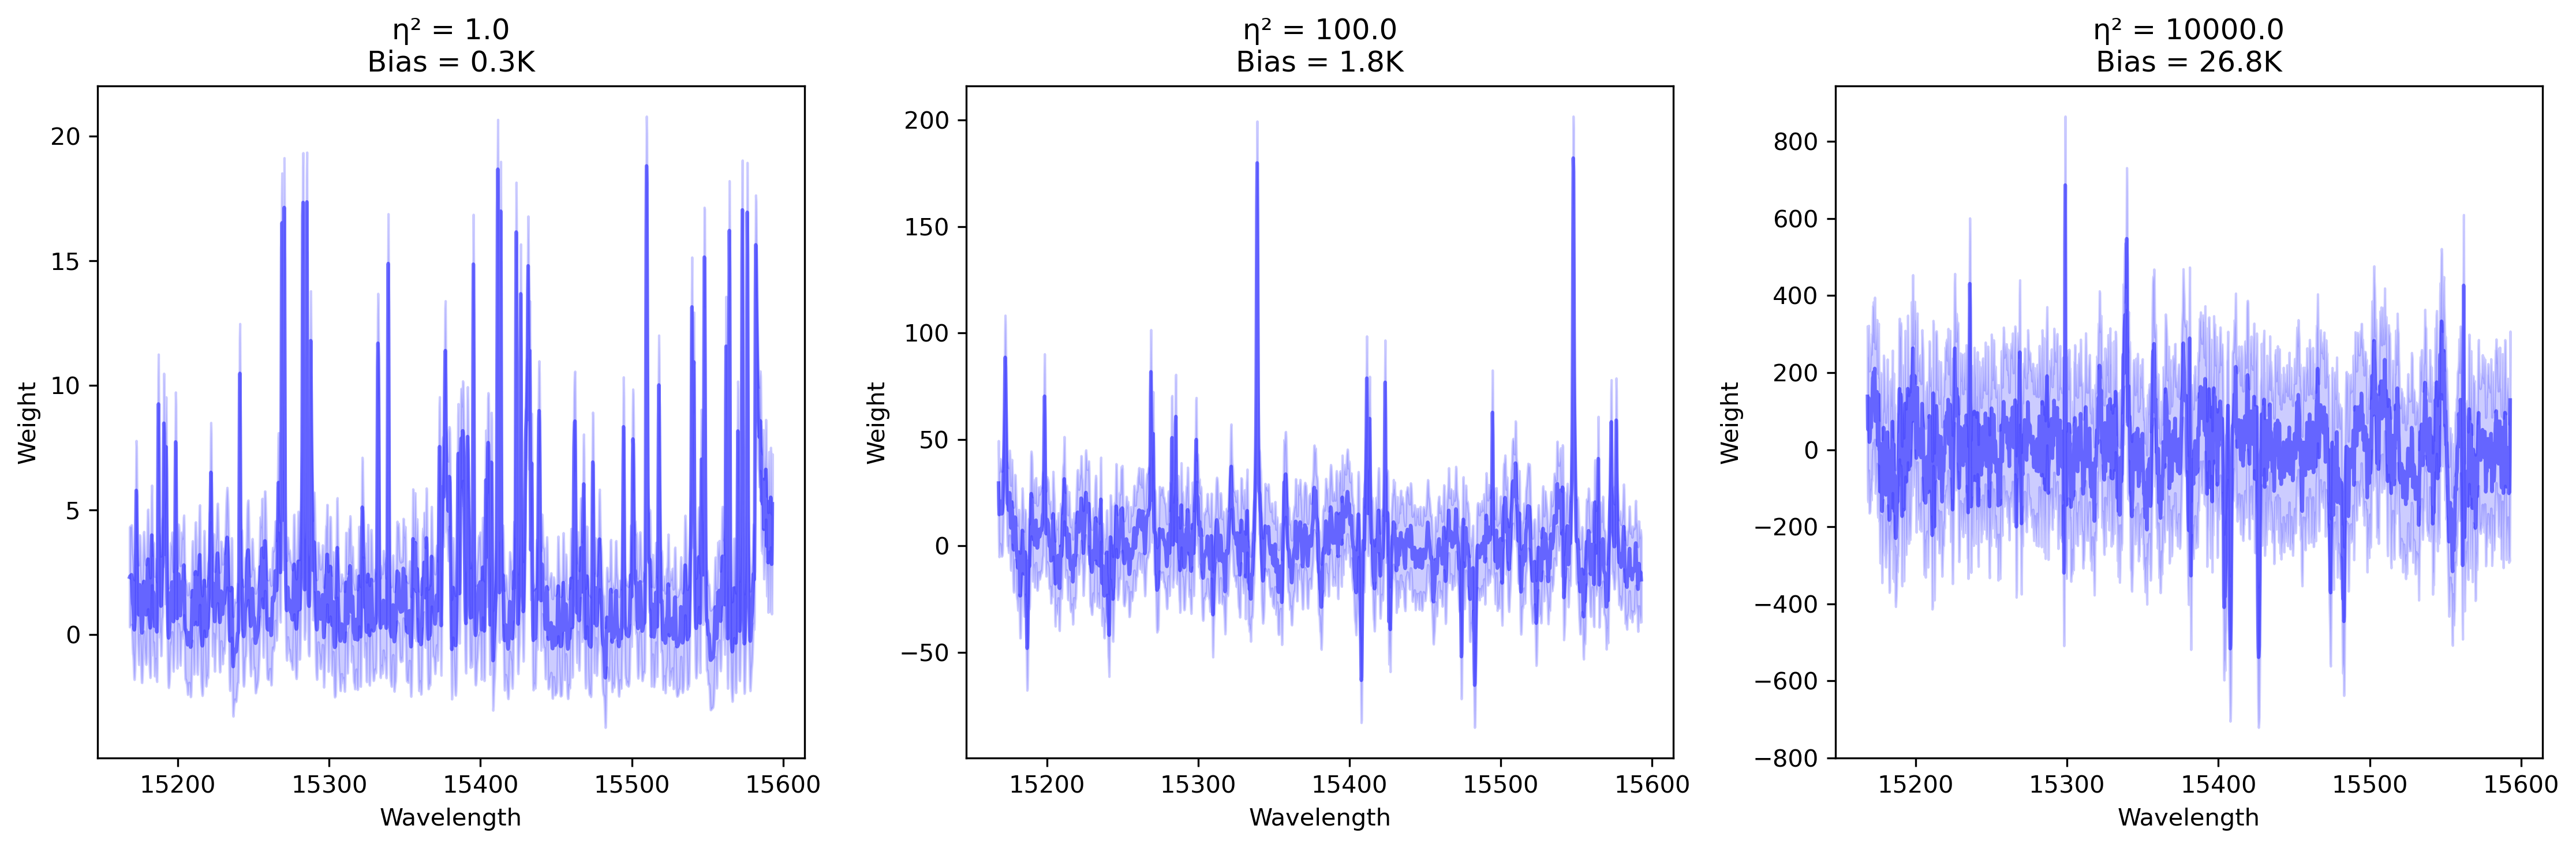

In [10]:
def compute_posterior(Phi, t, sigma, eta2):
    """
    Compute posterior distribution parameters for Bayesian linear regression
    
    Parameters:
    -----------
    Phi : array, shape (N, M)
        Design matrix (N spectra × 2001 features)
    t : array, shape (N,)
        Target temperatures in Kelvin
    sigma : array, shape (N,)
        Temperature uncertainty for each star in Kelvin
    eta2 : float
        Prior variance parameter
        
    Returns:
    --------
    m_N : array, shape (2001,)
        Posterior mean (2000 spectral weights + 1 bias)
    S_N : array, shape (2001, 2001)
        Posterior covariance
    """
    N, M = Phi.shape
    
    # Setup prior
    S0_inv = np.eye(M) / eta2
    
    # Compute data precision matrix (inverse of noise covariance)
    S_inv = np.diag(1 / sigma**2)
    
    # Compute posterior covariance
    S_N = np.linalg.inv(S0_inv + Phi.T @ S_inv @ Phi)
    
    # Compute posterior mean
    m_N = S_N @ (Phi.T @ S_inv @ t)
    
    return m_N, S_N

# Compute posteriors for different prior strengths
eta2_values = [1.0, 100.0, 10000.0]
posteriors = [compute_posterior(Phi_train, t_train, sigma_train, eta2) 
             for eta2 in eta2_values]

# Visualize the spectral weights
plt.figure(figsize=(15, 5))

for i, (m_N, S_N) in enumerate(posteriors):
    plt.subplot(1, 3, i+1)
    
    # Plot spectral weights (excluding bias)
    spectral_weights = m_N[:-1]
    plt.plot(wavelength[:2000], spectral_weights, 'b-', alpha=0.5)
    
    # Add uncertainty bands (±2σ)
    weight_std = np.sqrt(np.diag(S_N[:-1, :-1]))
    plt.fill_between(wavelength[:2000], 
                     spectral_weights - 2*weight_std,
                     spectral_weights + 2*weight_std,
                     color='b', alpha=0.2)
    
    plt.title(f'η² = {eta2_values[i]}\nBias = {m_N[-1]:.1f}K')
    plt.xlabel('Wavelength')
    plt.ylabel('Weight')
    
plt.tight_layout()
plt.show()

These plots reveal how the prior strength $\eta^2$ affects our spectral weights, which are crucial for understanding our model:

Remember that each weight $w_i$ ($i=1...2000$) represents how much the flux at wavelength $i$ contributes to the temperature prediction. A positive weight means higher flux at that wavelength predicts higher temperature, while a negative weight means higher flux predicts lower temperature. The final weight $w_{2001}$ is our bias term, representing a base temperature level.

1. Strong Prior ($\eta^2 = 1.0$): With small weights and narrow uncertainty bands, this prior forces most wavelengths to have minimal impact on predictions. It creates a conservative model that's resistant to noise but might miss real spectral features. Similar to heavy regularization we saw in Part 1, it helps prevent overfitting and is particularly useful when data is noisy or we have few training examples.

2. Medium Prior ($\eta^2 = 100.0$): This prior produces moderate weights with reasonable uncertainties, allowing wavelengths to contribute meaningfully when supported by data. It strikes a balance between trusting the data and preventing overfitting, similar to optimal regularization strength in Part 1. This makes it a good default choice for most applications.

3. Weak Prior ($\eta^2 = 10000.0$): Characterized by larger weights with wide uncertainty bands, this prior allows wavelengths to have strong influence on predictions. It's close to the maximum likelihood solution we saw in Part 1 and lets the data dominate, which can lead to overfitting. While it can capture subtle spectral features, it's also more sensitive to noise.

Notice how the uncertainty bands (shaded regions) grow with $\eta^2$. This reflects our increasing uncertainty about the true importance of each wavelength. The bands show where we expect the "true" weights to lie with about 95% probability (±2σ).

The patterns in the weights also reveal physical insights. For example, certain wavelength regions consistently show strong positive or negative weights across different prior strengths, suggesting they're particularly important for temperature determination. This matches our astronomical knowledge about spectral features sensitive to temperature.


## Part 4: Making Predictions with Uncertainty

The Bayesian framework we developed in Part 3 gives us a natural way to make predictions with uncertainty. For a new stellar spectrum $\boldsymbol{\phi}_*$, we want the complete predictive distribution that accounts for all uncertainties in our model. This distribution is obtained by integrating over all possible weights, weighted by their posterior probabilities:

$$p(t_*|\boldsymbol{\phi}_*, \mathcal{D}) = \int p(t_*|\boldsymbol{\phi}_*, \mathbf{w})p(\mathbf{w}|\mathcal{D})d\mathbf{w}$$

Because both our likelihood and posterior are Gaussian, this integral has a convenient closed-form solution. The predictive distribution for a new temperature is Gaussian:

$$p(t_*|\boldsymbol{\phi}_*, \mathcal{D}) = \mathcal{N}(t_*|\mu_*, \sigma_*^2)$$

with mean $\mu_* = \boldsymbol{\phi}_*^T\mathbf{m}_N$ and variance $\sigma_*^2 = \boldsymbol{\phi}_*^T\mathbf{S}_N\boldsymbol{\phi}_* + \sigma_\text{noise}^2$. This variance has two components: uncertainty in our weights ($\boldsymbol{\phi}_*^T\mathbf{S}_N\boldsymbol{\phi}_*$) and intrinsic noise in temperature measurements ($\sigma_\text{noise}^2$). This builds directly on our previous work - the naive error estimates from Part 1, the measurement uncertainties from Part 2, and the Bayesian weight posteriors from Part 3. Let's see how these uncertainties play out in practice:

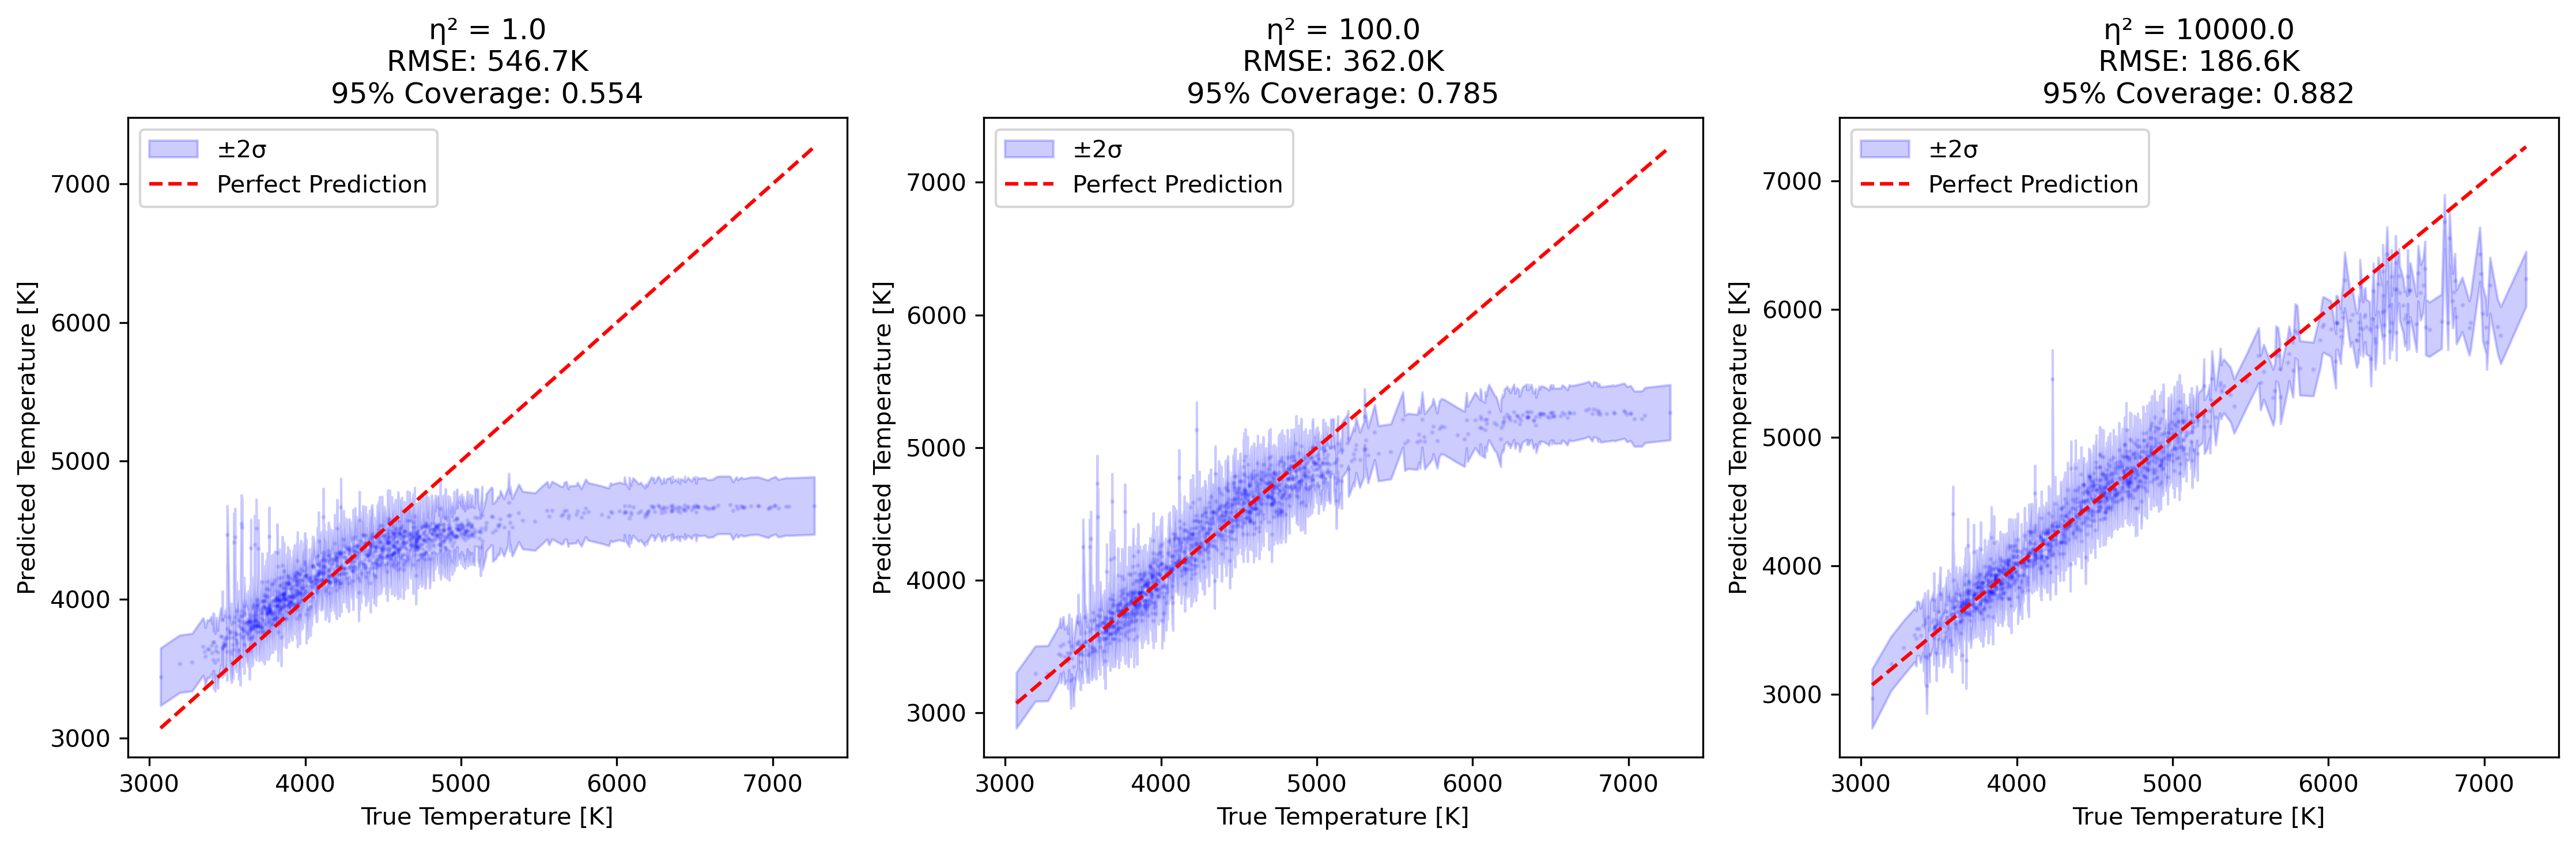

In [11]:
def predict_with_uncertainty(Phi_new, m_N, S_N, noise_var):
    """
    Make predictions with uncertainty for new spectra
    
    Parameters:
    -----------
    Phi_new : array, shape (N_new, 2001)
        Design matrix for new spectra
    m_N : array, shape (2001,)
        Posterior mean weights
    S_N : array, shape (2001, 2001)
        Posterior covariance
    noise_var : float
        Observation noise variance
        
    Returns:
    --------
    pred_mean : array, shape (N_new,)
        Predictive means
    pred_std : array, shape (N_new,)
        Predictive standard deviations
    """
    # Compute predictive mean
    pred_mean = Phi_new @ m_N
    
    # Compute predictive variance (parameter uncertainty + noise)
    pred_var = np.sum(Phi_new @ S_N * Phi_new, axis=1) + noise_var
    pred_std = np.sqrt(pred_var)
    
    return pred_mean, pred_std

# Compare predictions from different priors
plt.figure(figsize=(15, 5))

for i, ((m_N, S_N), eta2) in enumerate(zip(posteriors, eta2_values)):
    # Get predictions
    noise_var = np.mean(sigma_test**2)  # Average noise variance
    pred_mean, pred_std = predict_with_uncertainty(Phi_test, m_N, S_N, noise_var)
    
    # Sort for better visualization
    sort_idx = np.argsort(t_test)
    t_sorted = t_test[sort_idx]
    pred_mean_sorted = pred_mean[sort_idx]
    pred_std_sorted = pred_std[sort_idx]
    
    plt.subplot(1, 3, i+1)
    plt.scatter(t_sorted, pred_mean_sorted, c='b', alpha=0.1, s=1)
    plt.fill_between(t_sorted, 
                     pred_mean_sorted - 2*pred_std_sorted,
                     pred_mean_sorted + 2*pred_std_sorted,
                     color='b', alpha=0.2, label='±2σ')
    plt.plot([t_test.min(), t_test.max()], 
             [t_test.min(), t_test.max()], 
             'r--', label='Perfect Prediction')
    
    # Calculate metrics
    rmse = np.sqrt(np.mean((t_test - pred_mean)**2))
    z_scores = (t_test - pred_mean) / pred_std
    coverage = np.mean(np.abs(z_scores) < 2)
    
    plt.title(f'η² = {eta2}\nRMSE: {rmse:.1f}K\n95% Coverage: {coverage:.3f}')
    plt.xlabel('True Temperature [K]')
    plt.ylabel('Predicted Temperature [K]')
    plt.legend()

plt.tight_layout()
plt.show()

Our analysis reveals important insights about prediction uncertainty in stellar temperature determination. The choice of prior strength profoundly affects our predictions. A strong prior leads to conservative predictions with small but potentially overconfident uncertainties. A medium-strength prior gives balanced predictions with realistic uncertainty estimates, while a weak prior allows more flexible predictions but at the cost of larger uncertainties.

The calibration of our uncertainties is crucial for reliable temperature determination. In a well-calibrated model, the ±2σ prediction intervals should contain about 95% of true temperatures. Our coverage analysis shows how well our model achieves this goal, with different prior strengths leading to varying degrees of calibration.

From a practical standpoint, choosing the right prior strength requires careful consideration of the trade-off between precision and reliability. Cross-validation can help select an appropriate η², but when in doubt, it's often better to err on the conservative side with a smaller value. 

Our model does have limitations. The linear approach may not capture all the complexity in the relationship between spectra and temperature, particularly across the full temperature range. For more precise results, one might consider separate models for different temperature regimes or account for the effects of other stellar parameters like metallicity. Nevertheless, this framework provides a solid foundation for making reliable temperature predictions with well-calibrated uncertainties from stellar spectra.

## Conclusion

In this tutorial, we've explored uncertainty quantification in linear regression through the lens of stellar spectroscopy, progressing from naive error estimates to fully Bayesian predictions. Our journey revealed several key insights:

1. Understanding Naive Error Estimates
   - Demonstrated why simple error estimates can be misleading
   - Found that regularization alone is insufficient when treating all measurements equally  
   - Observed significant gap between training RMSE (~72K) and test RMSE (~130K)

2. Incorporating Measurement Uncertainties
   - Introduced weighted least squares to handle heteroscedastic noise
   - Used chi-squared statistic for model calibration assessment
   - Properly accounted for varying precision in stellar measurements

3. Bayesian Linear Regression
   - Moved beyond point estimates to full posterior distributions
   - Explored impact of prior strength η²:
     - Strong priors: Conservative but potentially biased
     - Weak priors: Flexible but risk of overfitting

4. Complete Uncertainty Framework
   - Combined parameter uncertainty with measurement noise
   - Achieved well-calibrated prediction intervals
   - Demonstrated importance of comprehensive uncertainty quantification

The progression from simple error bars to full predictive distributions has given us a robust framework. While RMSE values may be comparable to simpler approaches, we now have reliable uncertainty estimates incorporating both measurement noise and model uncertainty.

### Future Directions

This tutorial focused on linear models for simplicity, but the principles extend to more sophisticated approaches. Future work might explore:
- Non-linear models with uncertainty quantification
- Joint modeling of temperature with other stellar parameters

Most importantly, we've seen how careful attention to uncertainty quantification leads to more reliable and interpretable models. In astronomy, knowing the uncertainty in our measurements is often as important as the measurements themselves.